In [4]:
import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic
import ollama

In [ ]:
#uncomment the code and provide the token while running the code in run time. 
#os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'XXXXXXXXXXXXXXXXXX')

In [5]:
load_dotenv() 
hf_token = os.environ['HF_API_TOKEN']
login(hf_token, add_to_git_credential=True)

In [6]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from items import Item
from testing import Tester

In [7]:
%matplotlib inline

In [8]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [9]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [10]:
# Read it back in

import csv

human_predictions = []
with open('human_input.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # Check if the row has enough elements to prevent the error
        if len(row) > 1:
            human_predictions.append(float(row[1]))

In [11]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $0.00 Truth: $374.41 Error: $374.41 SLE: 35.14 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $0.00 Truth: $225.11 Error: $225.11 SLE: 29.39 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $0.00 Truth: $61.68 Error: $61.68 SLE: 17.12 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $0.00 Truth: $599.99 Error: $599.99 SLE: 40.94 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $0.00 Truth: $16.99 Error: $16.99 SLE: 8.35 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $0.00 Truth: $101.79 Error: $101.79 SLE: 21.46 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $0.00 Truth: $289.00 Error: $289.00 SLE: 32.15 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $0.00 Truth: $635.86 Error: $635.86 SLE: 41.69 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $0.00 Truth: $65.99 Error: $65.99 SLE: 17.68 Ite

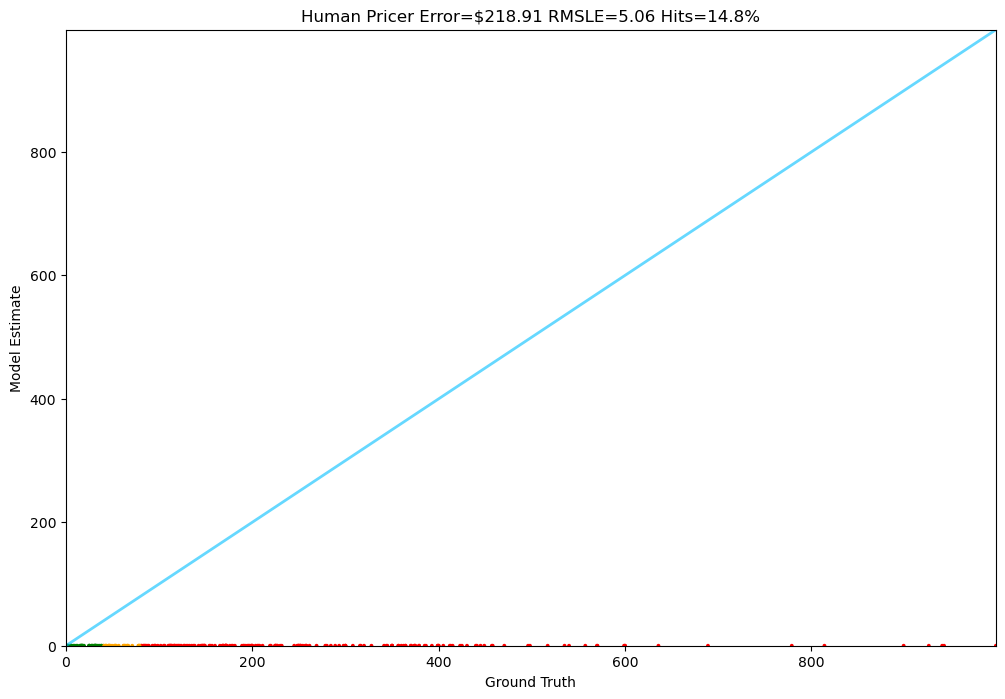

In [12]:
Tester.test(human_pricer, test)

In [13]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    #user_prompt = item.test_prompt()
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [14]:
messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [15]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [16]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [17]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = ollama.chat(
        model="llama3.2:latest", 
        messages=messages_for(item)
        #seed=42,
        #max_tokens=5
    )
    #reply = response.choices[0].message.content
    reply = response['message']['content']
    return get_price(reply)

In [18]:
test[0].price

374.41

In [ ]:
Tester.test(gpt_4o_mini, test)

1: Guess: $129.99 Truth: $374.41 Error: $244.42 SLE: 1.11 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $19.98 Truth: $225.11 Error: $205.13 SLE: 5.65 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $25.00 Truth: $61.68 Error: $36.68 SLE: 0.77 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $269.99 Truth: $599.99 Error: $330.00 SLE: 0.63 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $75.00 Truth: $16.99 Error: $58.01 SLE: 2.08 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $11.99 Truth: $31.99 Error: $20.00 SLE: 0.87 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $69.99 Truth: $101.79 Error: $31.80 SLE: 0.14 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $299.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $1,295.00 Truth: $635.86 Error: $659.14 SLE: 0.50 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $25.00 Truth: $65.99 Error: $40.99 SLE: 0.9

In [ ]:
# The function for ollama's deepseek-r1:1.5b

def ollama_deepseek(item):
    response = ollama.chat(
        model="deepseek-r1:1.5b", 
        messages=messages_for(item)
        #seed=42,
        #max_tokens=5
    )
    #reply = response.choices[0].message.content
    reply = response['message']['content']
    return get_price(reply)

In [ ]:
test[0].price

In [ ]:
Tester.test(ollama_deepseek, test)